In 2012, Jake Vanderplas wrote a blog-post entitled ["Why python is the last language you will need to learn"](http://jakevdp.github.io/blog/2012/09/20/why-python-is-the-last/). 

In the first part of the post, he presented the argument that the python scientific eco-system was sustainable partly because of the increased participation by more and more *developers*. This increased participation, thanks to github's excellent code-contribution and -review system, lowers the barriers to participation and helps the software evolve to meet the demands of users, and to fix bugs that are discovered by users. 

This is just one metric, but potentially a useful one, of code sustainability. 

## Is the growth in scipy contributions still continuing to this day?

In what follows, I try to reimplement jakevdp's initial analysis, and extend it to our day. 

The code is also easily resuable to track the changes in other git repositories, by changing the local file-system paths in code cell number 2, below.

I used [gitpython](http://pythonhosted.org/GitPython/0.3.1/) for the analaysis, as well as `pandas` for the time-series representation, `matplotlib` for visualization, and from the standard lib `datetime`, to keep track of those dates and times:  

In [1]:
import git
import pandas as pd
import datetime
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', **{'size'   : 18})
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')


Change the next cell, if you want to look at repos on your own file-system. 

In [2]:
repo_dir = ['/Users/arokem/source/numpy', 
            '/Users/arokem/source/scipy', 
            '/Users/arokem/source/matplotlib']
R = [git.Repo(d) for d in repo_dir]
log = [[c for c in rr.iter_commits()] for rr in R]

The following is the cell that does the actual counting and accumulating of authors. We end up with a list of `pandas` `Series` objects:

In [3]:
def process_repos(log):
    time_series = []

    for l in log:
        times = []
        n_authors = 0
        cum_authors = []
        authors = {}
        for c in l[-1::-1]:
            try:
                times.append(
                datetime.datetime.fromtimestamp(
                        time.mktime(time.gmtime(c.committed_date))))
                author = c.committer.name
            except:
                # Joergen has a name that's hard 
                # for gitpython to glob
                author= "Joergen Stenarsson" 
                times.append(times[-1])
            if author not in authors.keys():
                n_authors +=1
                authors[author] = 0

            authors[author] += 1
            cum_authors.append(n_authors)
        time_series.append(pd.Series(cum_authors, index=times))
    return time_series

time_series = process_repos(log)

We visualize the data in each one of our time-series. A call to `axvspan` can be used to highlight a certain period in the graph. Here, I've used it to indicate the (approximate) beginning of github migration in these projects, and the time at which Jake wrote his original post:

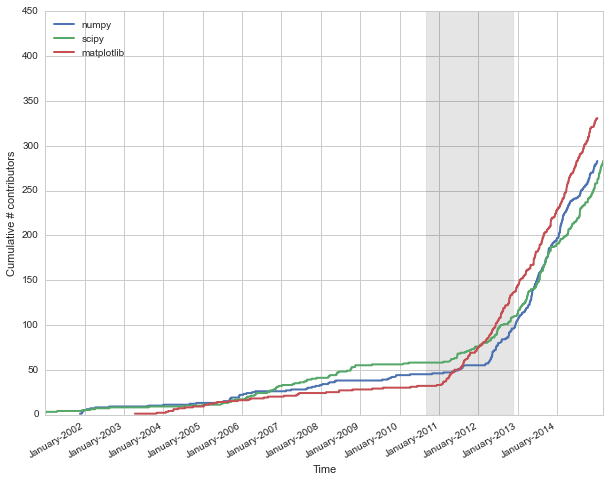

In [4]:
years= range(2002, 2015)

def plot_time_series(time_series):
    fig, ax = plt.subplots(1)
    for ii, ts in enumerate(time_series):
        ax = ts.plot(use_index=True, linewidth=2, 
                     label=repo_dir[ii].split('/')[-1])
        ax.figure.autofmt_xdate()
        fig.set_size_inches([10, 8])
        ax.set_xlabel('Time')
        ax.set_ylabel('Cumulative # contributors')
        ax.set_xticks([datetime.datetime(y, 2, 1) for y in years])
        ax.set_xticklabels(['January-%s'%y for y in years])
        ax.set_ylim([0, 450])
    plt.axvspan(datetime.datetime(2010, 10, 1), 
                datetime.datetime(2013, 1, 1), 
                facecolor='k', alpha=0.1)

    plt.legend(loc='upper left')
    
plot_time_series(time_series)


The answer to the question at the beginning of this notebook seems to be a resounding "yes!"

However, the story might be more complicated than just the effect of github on participation. For example, let's add `ipython` to the plot. 

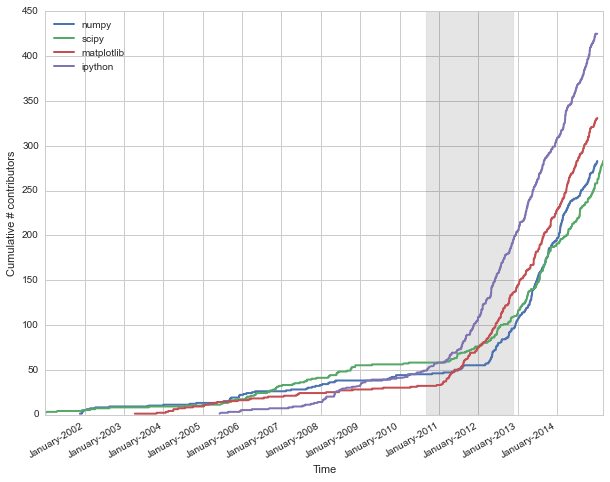

In [5]:
repo_dir = ['/Users/arokem/source/numpy', 
            '/Users/arokem/source/scipy', 
            '/Users/arokem/source/matplotlib', 
            '/Users/arokem/source/ipython']

R = [git.Repo(d) for d in repo_dir]
log = [[c for c in rr.iter_commits()] for rr in R]


time_series = process_repos(log)
plot_time_series(time_series)


IPython is important for two reasons. The first is that it has been on github since [May 2010](https://launchpad.net/ipython/+announcement/5798), approximately a year and a half before the other projects, but the rise in its accumulated number of developers doesn't happen until approximately mid-2011, approximately a year after the move to github. So, it seems that just moving to github by itself is not an immediate cause for an increase in new contributers. 

The other reason is that it might have actually had some influence on the dynamics evident in these plots. See how IPython first shoots up in mid-2011 (a year after it moved to github), together with matplotlib, and closely followed by scipy and numpy? In December 2011, the IPython team released version 0.12 of IPython. This release included a new feature: the interactive notebook. You can read the full historic perspective in [Fernando Perez' account of these events](http://blog.fperez.org/2012/01/ipython-notebook-historical.html). The notebook format, with which this very post was also written (I'll write more about the tools used to make that easy, at some future time) has attracted many people to using not only python, but specifically to using the scientific libraries with which IPython, and specifically the notebook, play so well. Since matplotlib figures were tightly integrated into the notebook, allowing the figures to be embedded into notebook documents since [James Gao's very first stab at this format](https://github.com/ipython/ipython/pull/179), these two tools are used together very naturally, and it is no surprise that their new-contributor trajectories so closely match. Numpy and scipy (together with other libraries, such as `pandas`) are of course natural complements to use together with these two. Note that the accumulation of number of IPython developers seems to take an upturn already in mid-2011, about 6 months before the release of 0.12. This might be because the notebook was merged into the `master` branch of the project already in [August](https://github.com/ipython/ipython/commit/25aaf34ec11a354ccb058620ceaef400def2aeda), but it's also possible that relase 0.11, with the introduction of an interactive Qt terminal, was already interesting enough to draw people's attention. For what it's worth, I didn't really start using the notebook myself until April 2012. Behind the curve, as always. 

Now - I am not suggesting that IPython by itself caused people to also use the other libraries. Rather, I would argue that the IPython notebook signalled the maturing of the tools to such a degree that the world was ready for the perfect storm. This includes github, and coincides very nicely with [their growth](http://venturebeat.com/2013/12/23/github-doubled-its-repositories-in-2013-from-5-to-10-million/). But, at the same time, it looks like people were [not writing as much C code anymore](https://www.openhub.net/languages/compare?measure=commits&percent=true&l0=c&l1=python&l6=-1&commit=Update), so the github effect certainly didn't apply to all of open source software.

Other important factors include the dramatic improvement in the ease with which python libraries could be installed. This started with the release of the Enthought Python Distribution [back in Spring 2008](http://blog.enthought.com/general/epd-the-kitchen-sink-included-python-distribution/#.VBPHVmR7TSI), and continued with the release of Anaconda a few years later. I think that it's fair to say that these things together allowed this explosion to occur. Another factor could be that between November 2011 and March 2014, [Software Carpentry](software-carpentry.org) held about 140 workshops, teaching about 4500 scientists how to use computers (as mentioned [here](http://arxiv.org/pdf/1307.5448.pdf)). Python has been the most commonly taught programming language during this entire duration (and apparently long before that too), and the IPython notebook was introduced into teaching in [2012](http://software-carpentry.org/blog/2012/10/transitioning-to-the-ipython-notebook.html). This means that many scientists now get their first introduction to python in the notebook. Because Software carpentry at the same time teaches students how to use git and github this making them prime users, and eventually contributors, to all of these libraries, and to the eco-system of computing surrounding them. 
